In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from PIL import Image
import shutil as sh
import cv2
from tqdm.auto import tqdm
import yaml

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.1/107.7 GB disk)


In [3]:
#!unzip 'data.zip'

In [4]:
train_dir = './data/training_images'
test_dir = './data/testing_images'

print('Training images: ', len(os.listdir(train_dir)))
print('Testing images: ', len(os.listdir(test_dir)))

Training images:  1001
Testing images:  175


**Process data**

In [5]:
df = pd.read_csv('./data/train_solution_bounding_boxes (1).csv')

df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB


In [7]:
df.shape

(559, 5)

Image shape:  (380, 676, 3)
image    vid_4_10480.jpg
xmin          473.982634
ymin          172.852317
xmax          602.138929
ymax          231.050515
Name: 10, dtype: object


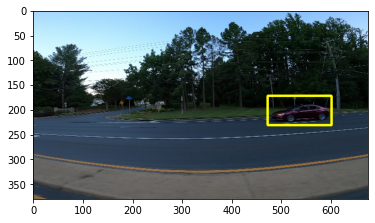

In [8]:
index = 10

image = plt.imread(train_dir + "/" + df.iloc[index][0])
IMAGE_SHAPE = image.shape
print('Image shape: ', IMAGE_SHAPE)
print(df.iloc[index])

min = (int(df.iloc[index][1]), int(df.iloc[index][2]))
max = (int(df.iloc[index][3]), int(df.iloc[index][4]))
cv2.rectangle(image, min, max, color = (255, 255, 0), thickness = 3)
plt.imshow(image)

In [9]:
# Get x_center, y_center, w, h from dataset
img_h, img_w, num_channels = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2])

df['x_center'] = ((df['xmin'] + df['xmax']) /2) / img_w
df['y_center'] = ((df['ymin'] + df['ymax']) /2) / img_h
df['w'] = (df['xmax'] - df['xmin']) / img_w
df['h'] = (df['ymax'] - df['ymin']) / img_h
df['classes'] = 0

df.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [10]:
if not os.path.exists('data'):
    os.makedirs('data')
    os.makedirs('data/fold{0}'.format(0))

In [11]:
index= list(set(df.image))
source = 'training_images'

for fold in [0]:
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name, mini in tqdm(df.groupby('image')):
        if name in val_index:
            path2save = 'val/'
        else:
            path2save = 'train/'
        if not os.path.exists('data/fold{}/labels/'.format(fold) + path2save):
            os.makedirs('data/fold{}/labels/'.format(fold) + path2save)
        with open('data/fold{}/labels/'.format(fold) + path2save + name + '.txt', 'w+') as f:
            row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
                f.write('\n')
        if not os.path.exists('data/fold{}/images/{}'.format(fold, path2save)):
            os.makedirs('data/fold{}/images/{}'.format(fold, path2save))
        sh.copy('data/{}/{}'.format(source, name), 'data/fold{}/images/{}/{}.jpg'.format(fold, path2save, name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [20]:
# dataset.yaml file

yaml_dict ={'path': 'yolov5/',
            'train': 'data/fold0/images/train',
            'val': 'data/fold0/images/val',
            'test': '',
            'names': ['car']
           }

with open ('data/dataset.yaml', 'w') as file:
    yaml.dump(yaml_dict, file)
    
with open('data/dataset.yaml', 'r') as f:
    print(f.read())

names:
- car
path: yolov5/
test: ''
train: data/fold0/images/train
val: data/fold0/images/val



**Train yolo5s model on training set**

In [21]:
!python train.py --batch 12 --epochs 12 --data dataset.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=12, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=

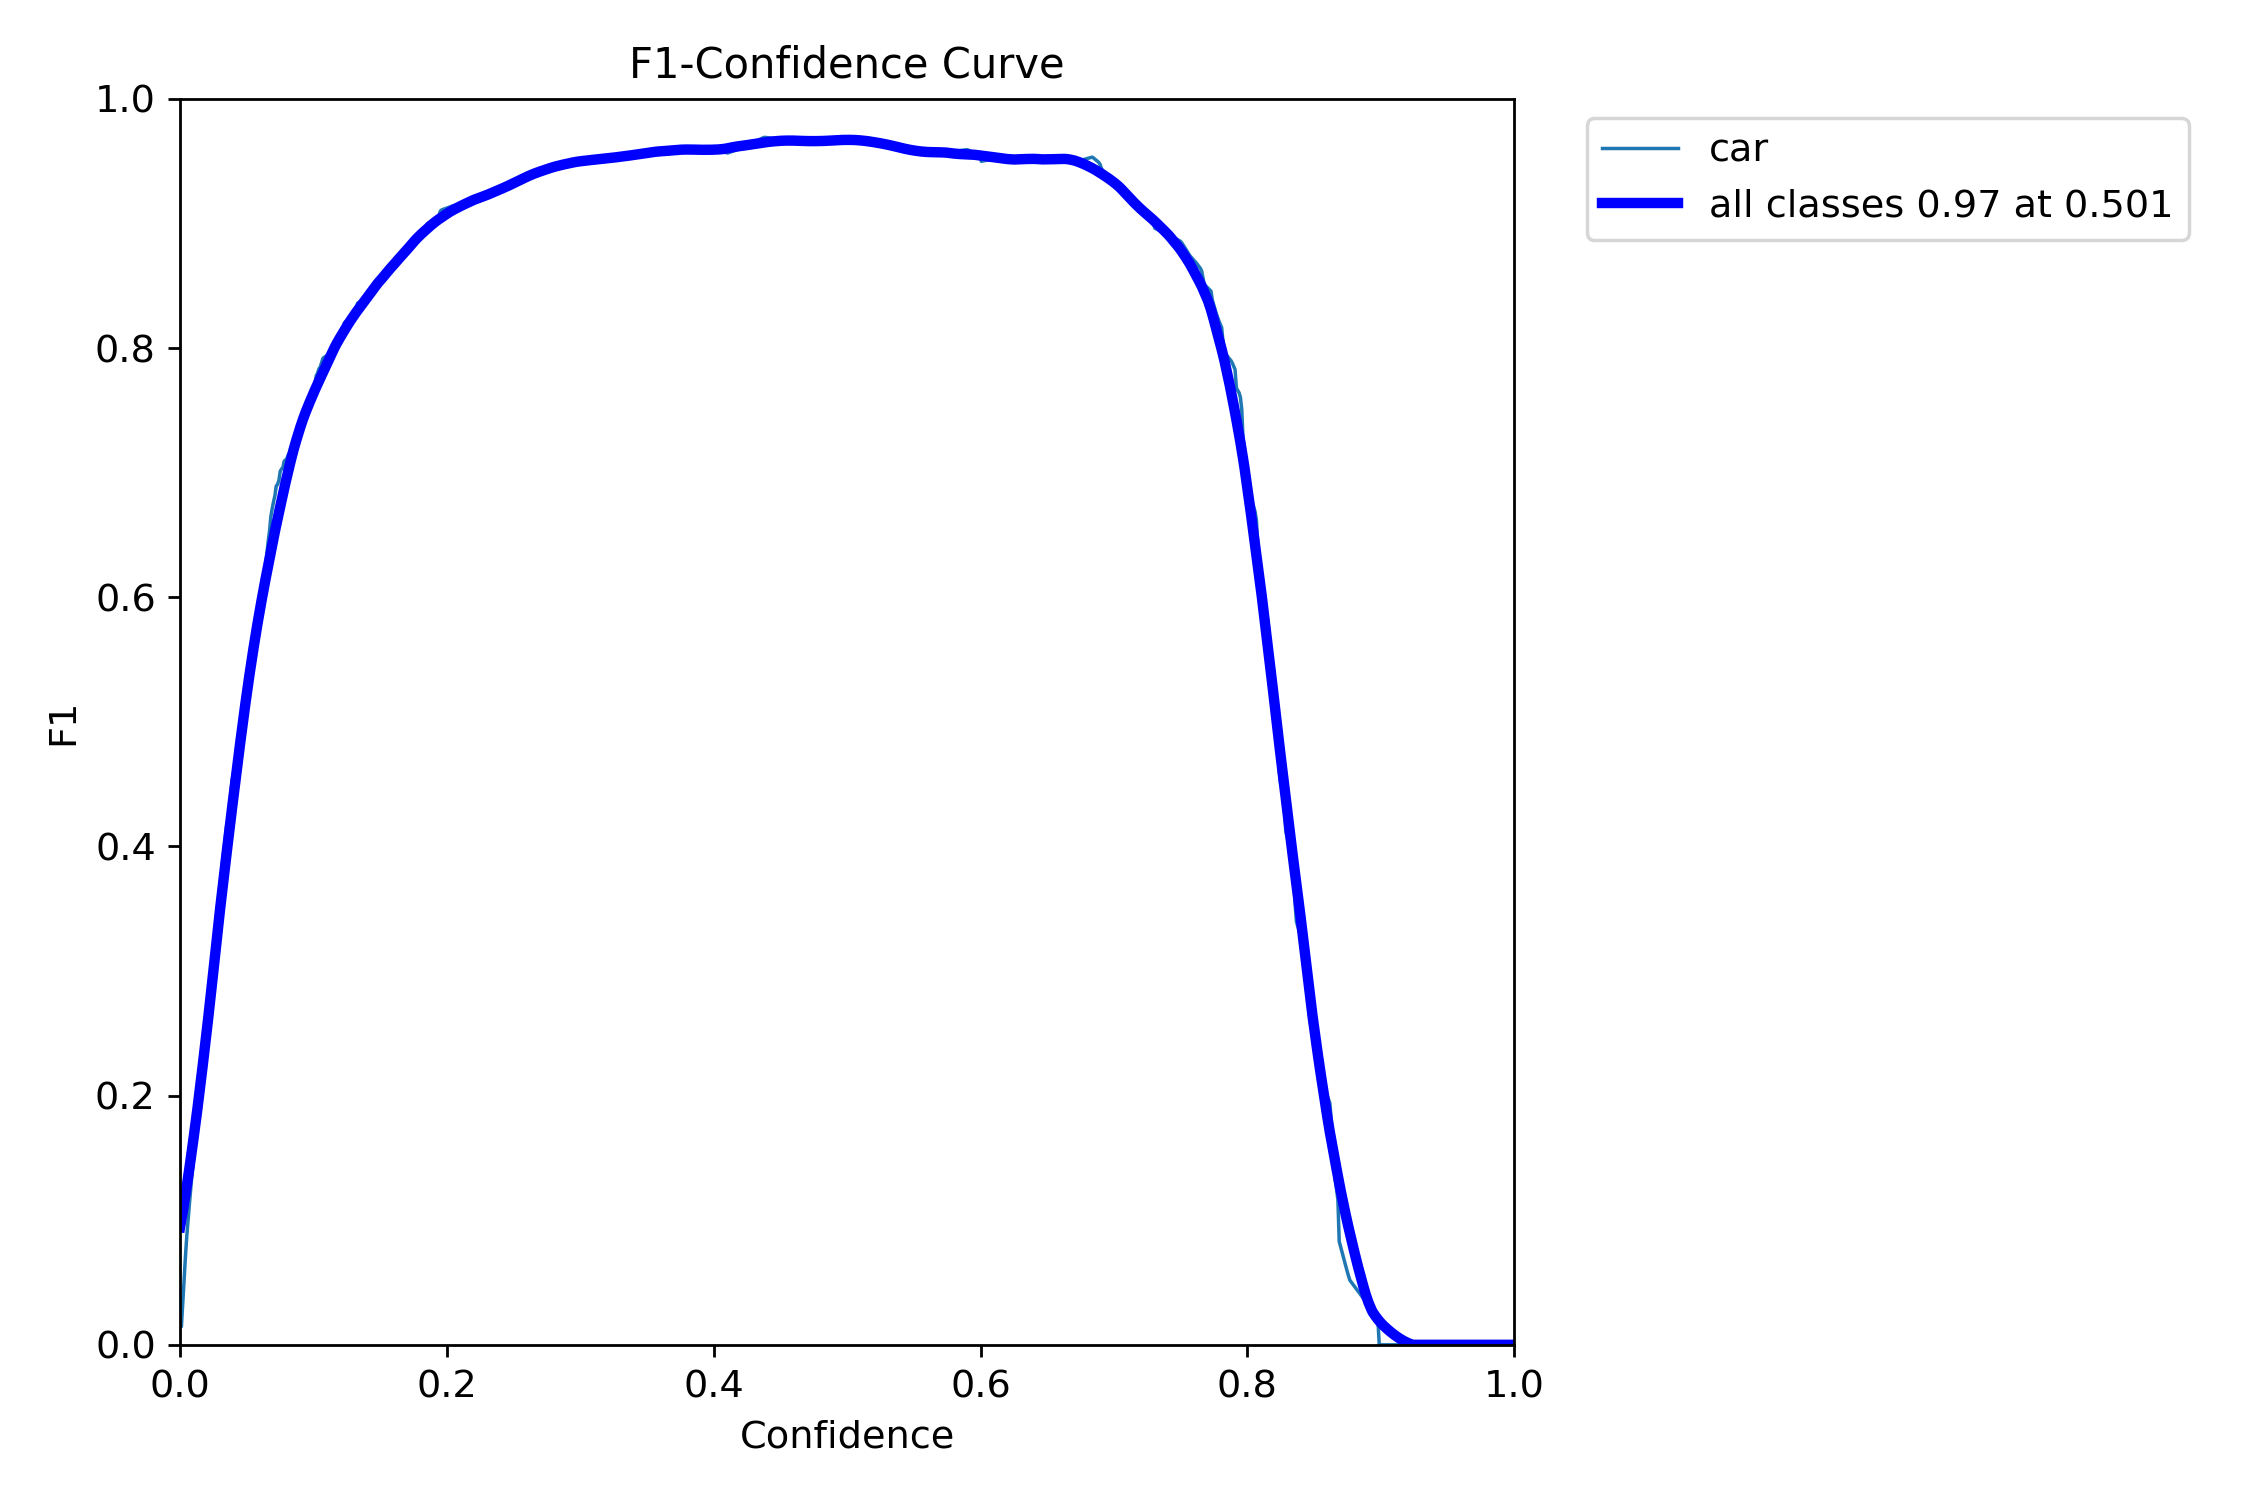

In [22]:
Image.open('runs/train/exp5/F1_curve.png')

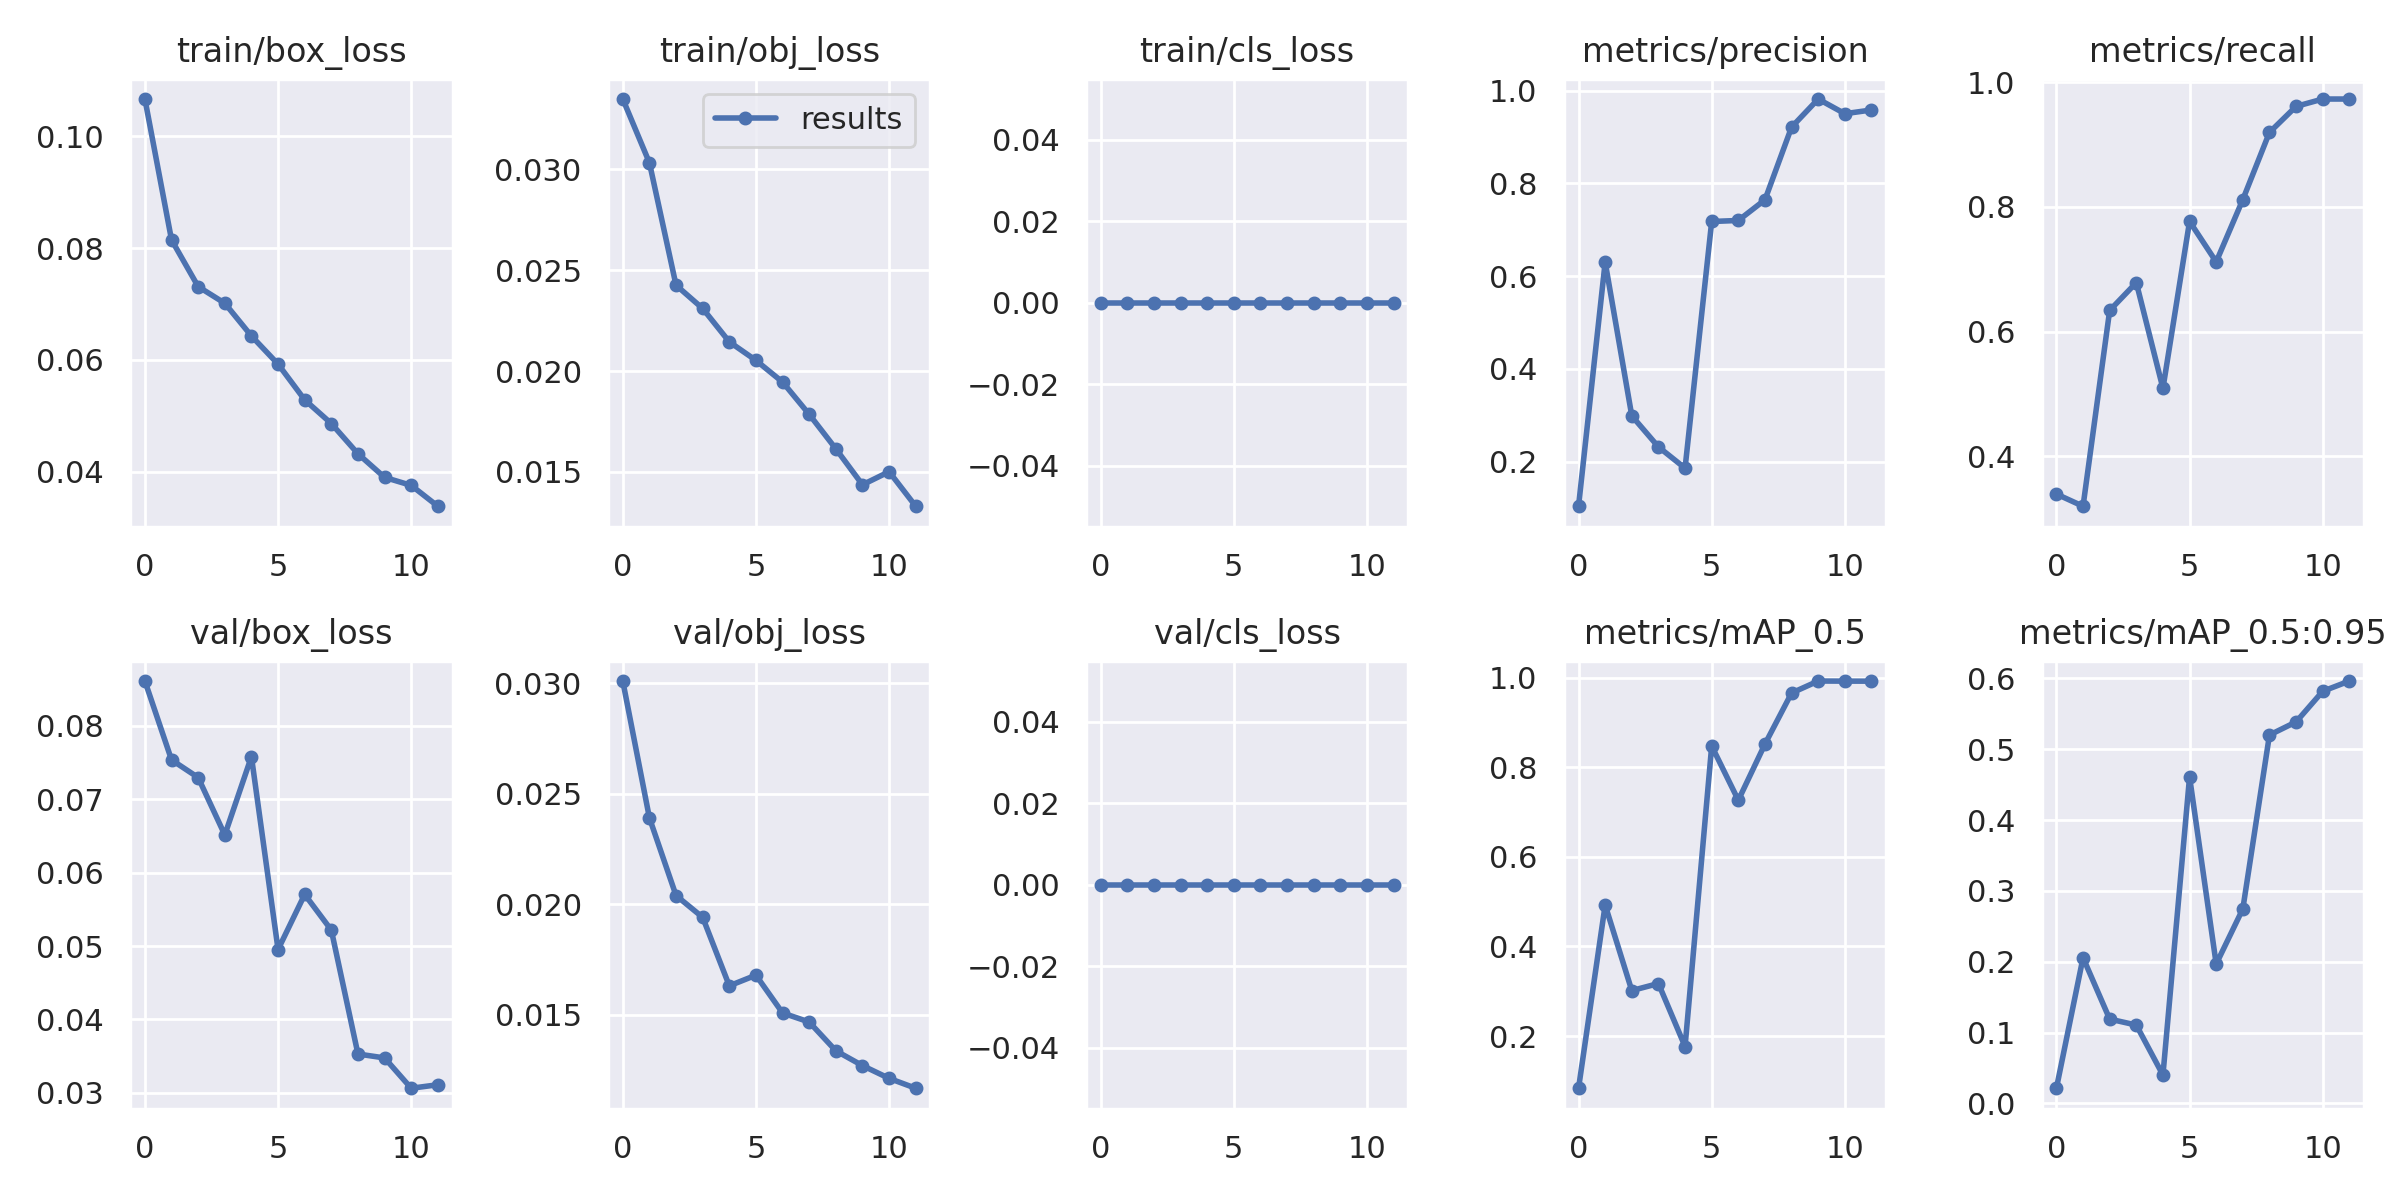

In [23]:
Image.open('runs/train/exp5/results.png')

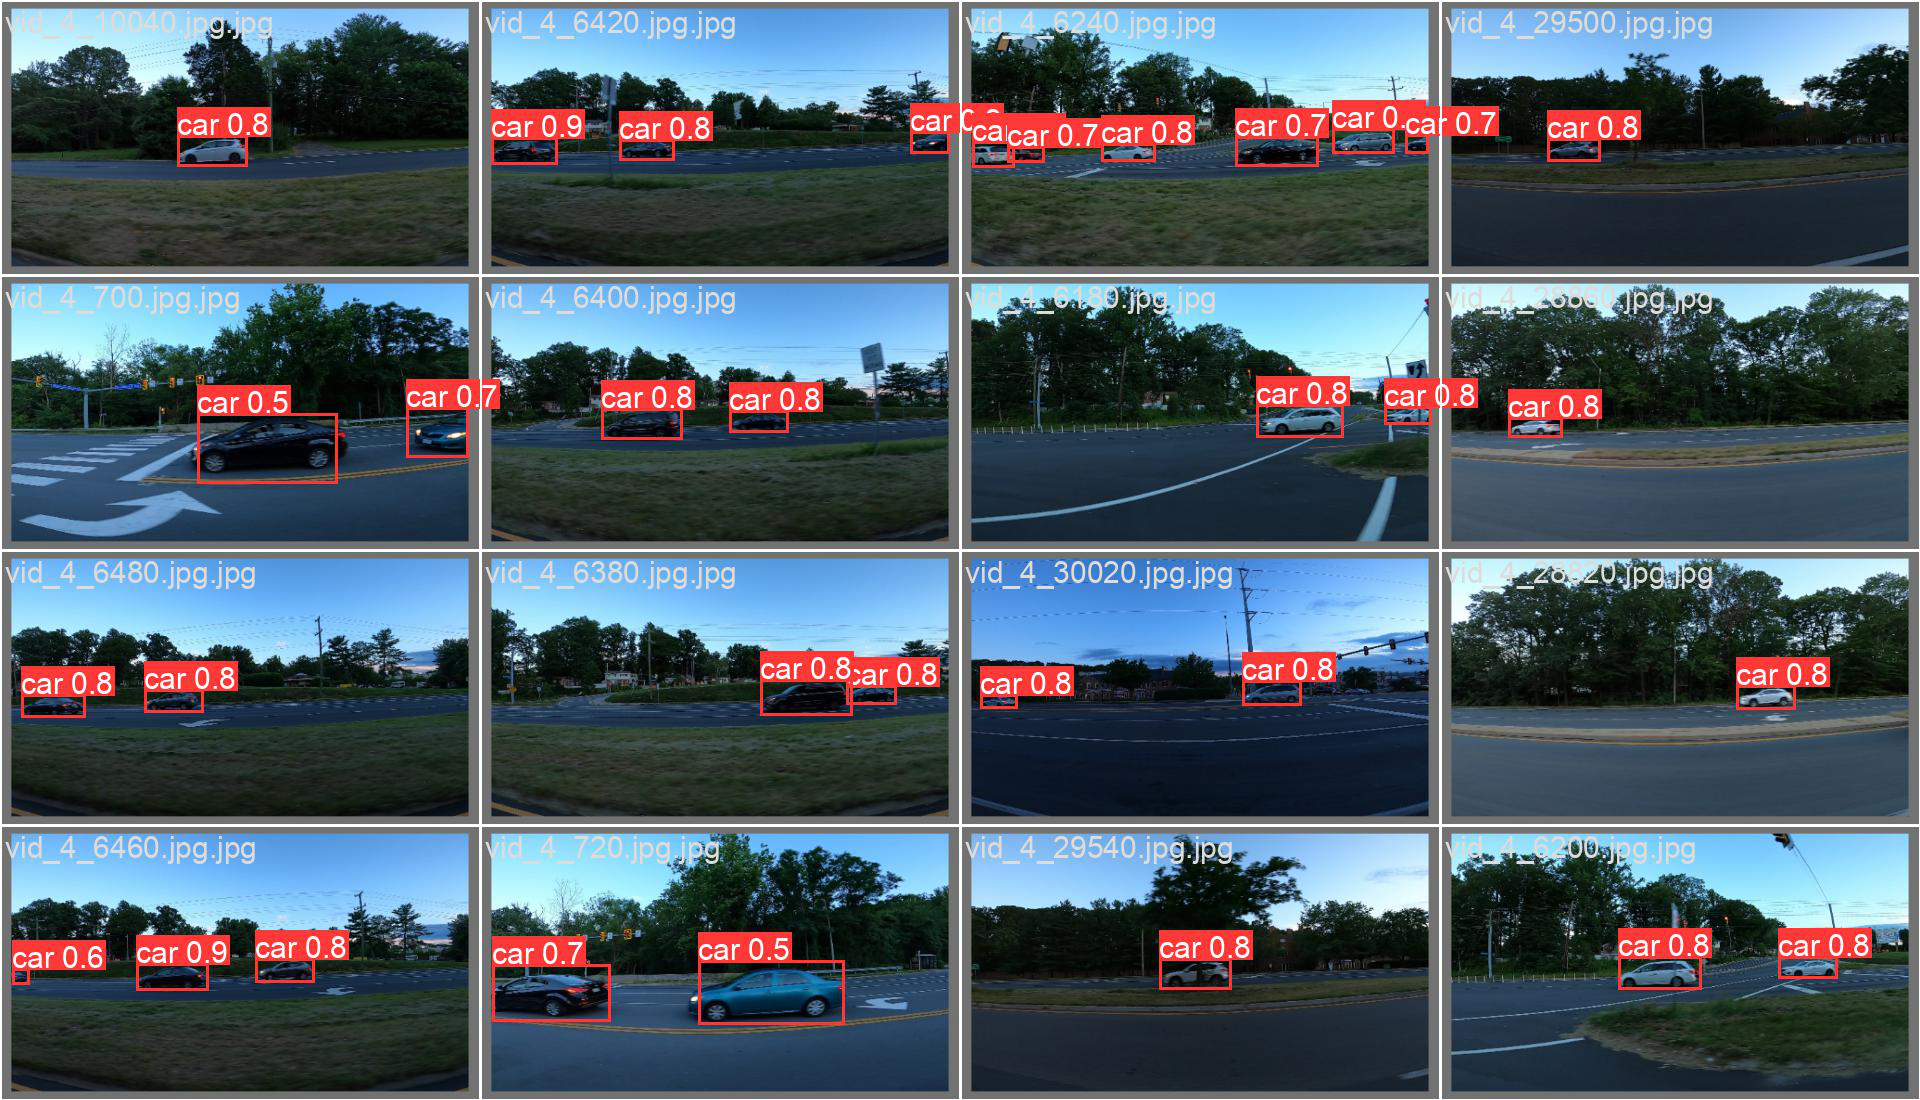

In [26]:
Image.open('runs/train/exp5/val_batch0_pred.jpg')

**Perform Inference on test set**

In [29]:
!python detect.py --conf 0.6 --iou-thres 0.5 --source data/testing_images --weights runs/train/exp5/weights/best.pt

detect: weights=['runs/train/exp5/weights/best.pt'], source=data/testing_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/175 /content/yolov5/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 222.5ms
image 2/175 /content/yolov5/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 224.9ms
image 3/175 /content/yolov5/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 221.8ms
image 4/175 /content/yolov5/data/testing_images/vid_5_25160.jpg: 384x640 (no 

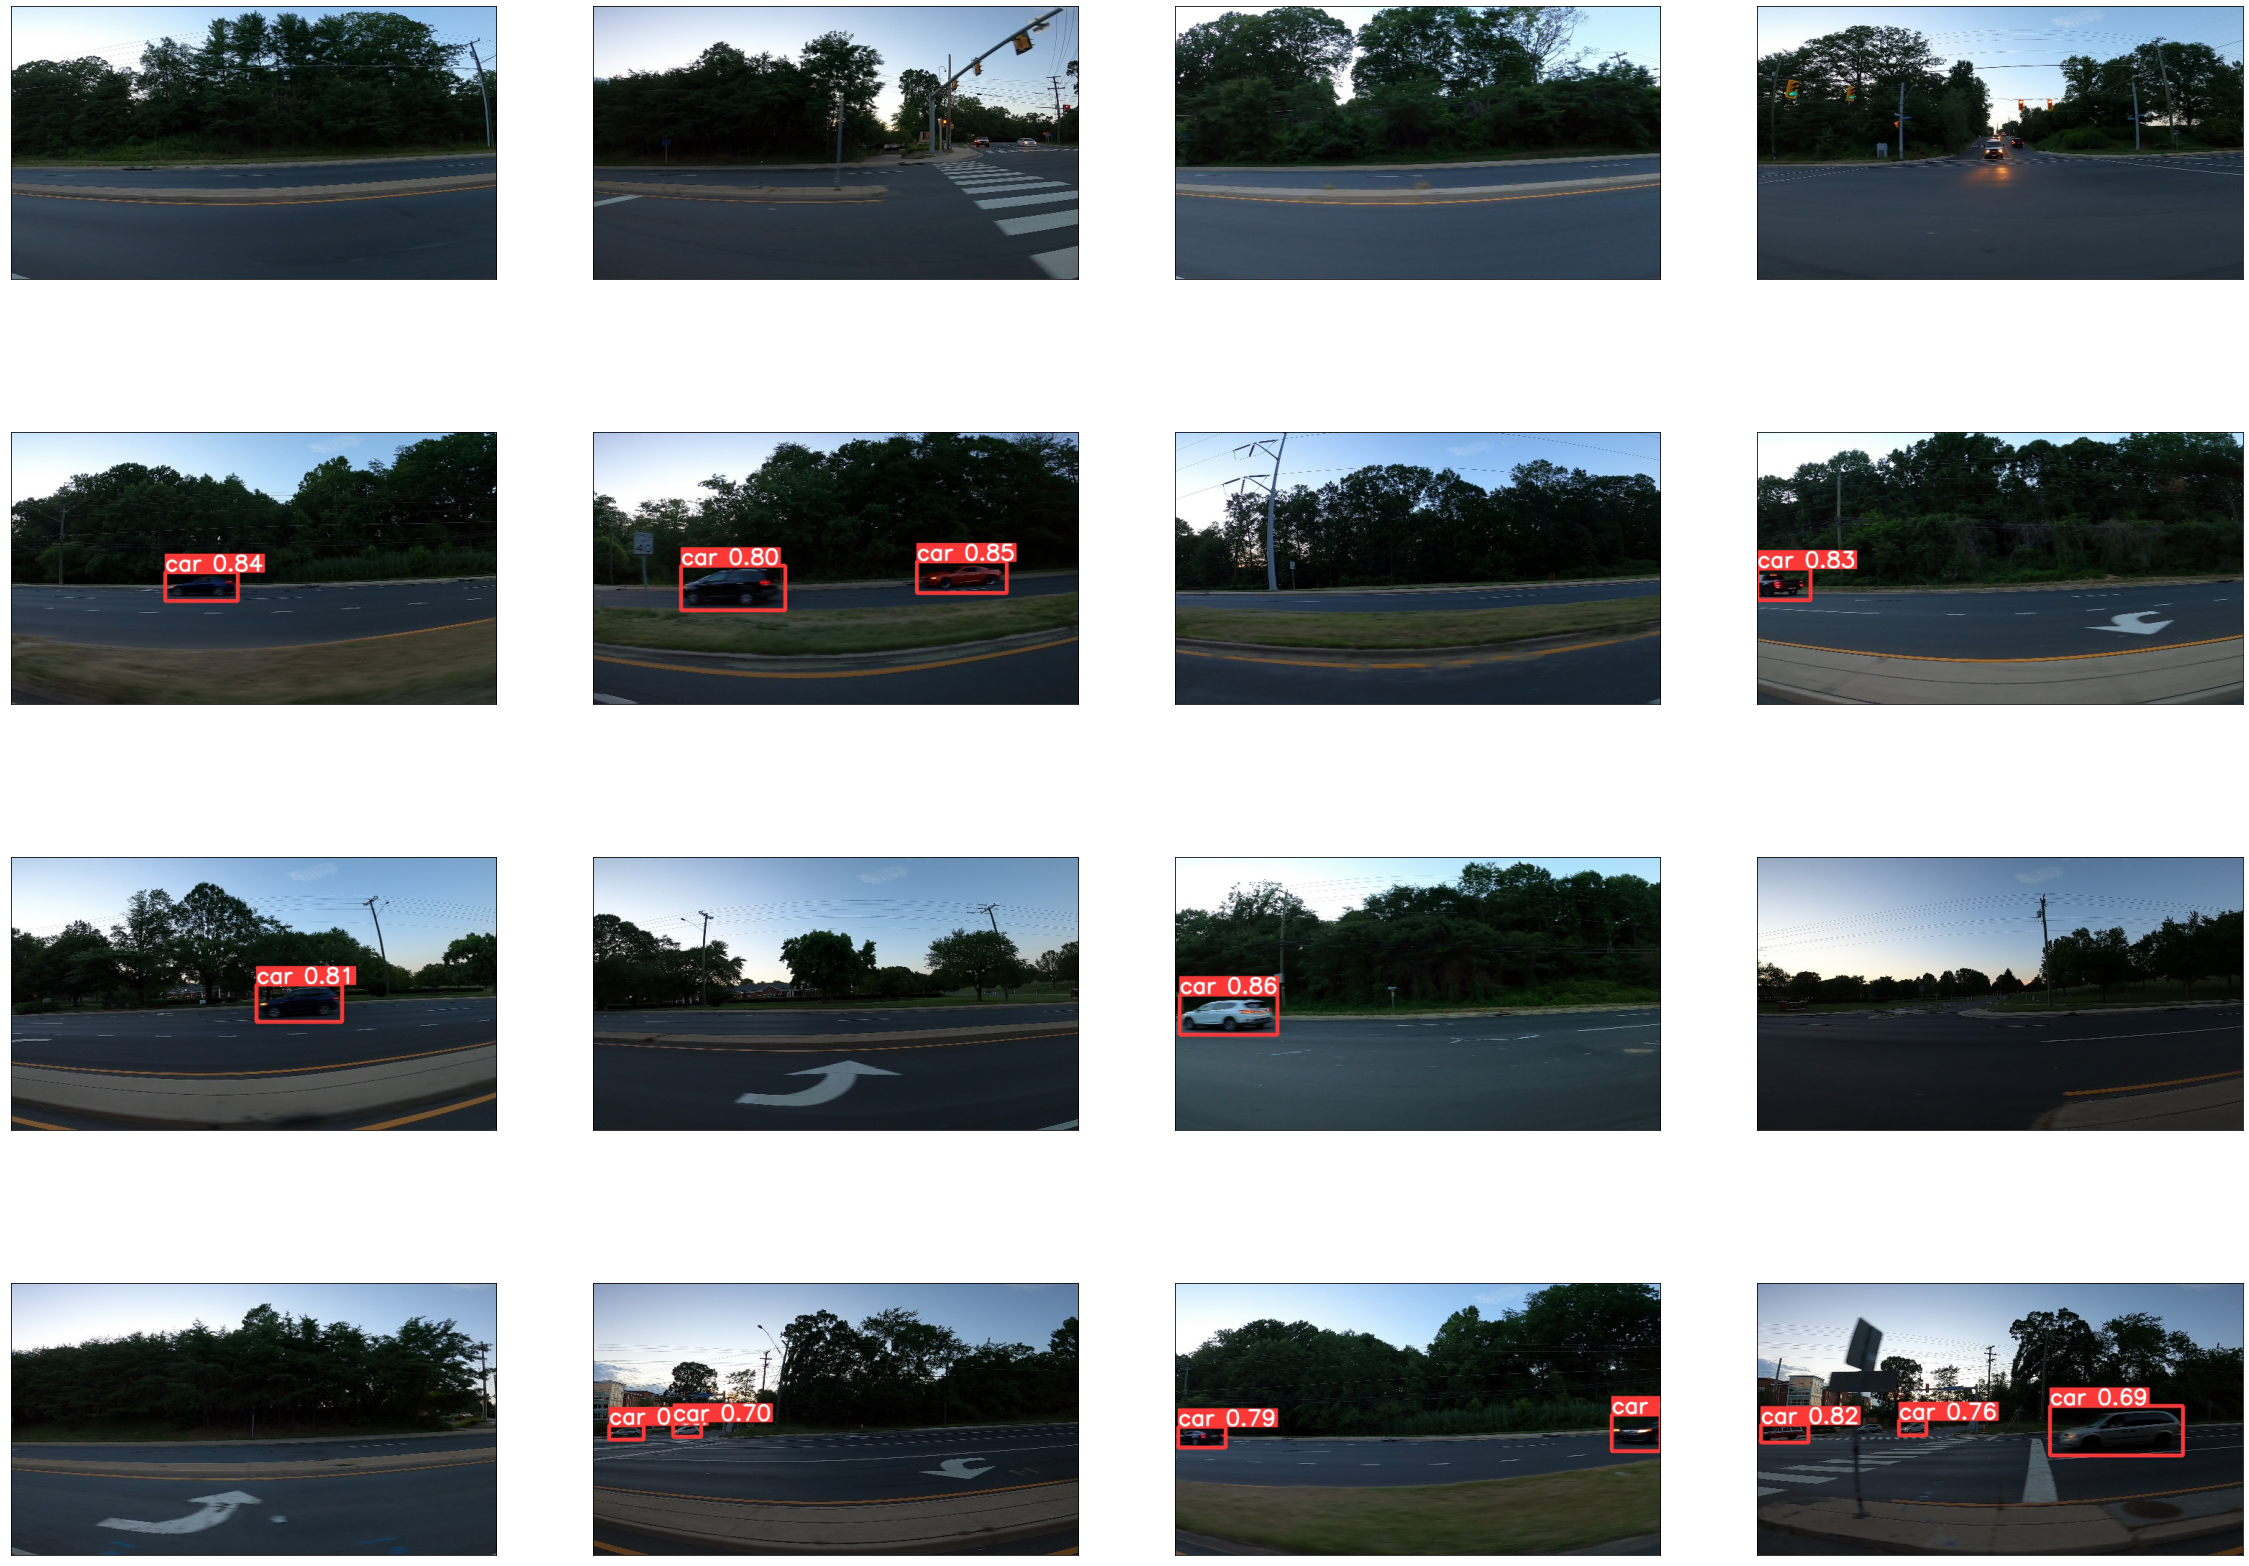

In [42]:
import glob
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img in glob.glob('runs/detect/exp3/*.jpg'):
    images.append(mpimg.imread(img))

plt.figure(figsize=(40, 30))
for i in range(16):
  rand = np.random.randint(0,len(images))
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[rand])
  plt.xticks([])
  plt.yticks([])

**Perform Inference on a Video**

In [43]:
!python detect.py --conf 0.6 --iou-thres 0.5 --source data/car.mp4 --weights runs/train/exp5/weights/best.pt

detect: weights=['runs/train/exp5/weights/best.pt'], source=data/car.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1501) /content/yolov5/data/car.mp4: 384x640 2 cars, 252.3ms
video 1/1 (2/1501) /content/yolov5/data/car.mp4: 384x640 2 cars, 256.9ms
video 1/1 (3/1501) /content/yolov5/data/car.mp4: 384x640 2 cars, 230.1ms
video 1/1 (4/1501) /content/yolov5/data/car.mp4: 384x640 2 cars, 223.6ms
video 1/1 (5/1501) /content/yolov5/data/car.mp4: 384x640 2 cars, 228.5ms
video 1/1 (6/